<a href="https://colab.research.google.com/github/sayuj-choudhari/pairs_trading_classifier_model/blob/main/pairs_trading_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from scipy.stats import skew, kurtosis

from scipy.stats import pointbiserialr
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import warnings
import os

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
import math

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

In [3]:
crsp_data = pd.read_csv("/content/crsp_daily_2019-2023.zip")

<ipython-input-3-86d194efe31c>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp_data = pd.read_csv("/content/crsp_daily_2019-2023.zip")


In [4]:
# Identify US common shares
shrcds = [10,11]
exchcds = [1,2,3]
shrcd_mask = crsp_data['SHRCD'].apply(lambda x: True if x in shrcds else False)
exchcd_mask = crsp_data['EXCHCD'].apply(lambda x: True if x in exchcds else False)

# Keep only US common shares
crsp_data = crsp_data[shrcd_mask&exchcd_mask]

In [5]:
crsp_data['date'] = pd.to_datetime(crsp_data['date'])
crsp_data['RET'] = pd.to_numeric(crsp_data['RET'], errors='coerce')

In [6]:
  def calculate_rsi(returns):
      up_moves = [r for r in returns if r > 0]
      down_moves = [-r for r in returns if r < 0]
      if len(up_moves) == 0:
          return 0
      elif len(down_moves) == 0:
          return 100
      avg_up = np.mean(up_moves)
      avg_down = np.mean(down_moves)
      rs = avg_up / avg_down
      rsi = 100 - (100 / (1 + rs))
      return rsi

In [7]:
def hurst_exponent(time_series):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

In [8]:
def get_percentile(returns):
  returns_series = pd.Series(returns)

  # Calculate the percentile rank of the previous return within the previous 30 returns
  previous_return = returns_series.iloc[-1]
  previous_returns = returns_series
  percentile_rank = (previous_returns.rank(pct=True) * 100).iloc[-1]  # Convert to percentile rank

  # Normalize the percentile rank
  normalized_percentile_rank = percentile_rank / 100

  return normalized_percentile_rank

In [9]:
def remove_nan_inf(data):
    mask = ~np.isnan(data).any(axis=1) & ~np.isinf(data).any(axis=1)
    return data[mask]

In [10]:
stock_data = crsp_data.copy()

In [11]:
crsp_data = stock_data.sort_values(by = 'date')

crsp_data = crsp_data[crsp_data['date'] > '2021-01-01']


unique_dates = sorted(crsp_data['date'].unique())

window_size = 200

date_to_data = {date: crsp_data[crsp_data['date'] == date] for date in unique_dates}

In [12]:
def build_train_set(returns, returns1, returns2):
  train_data = []
  valid_data = []

  for i in range(len(returns) - 40, len(returns)):
    window_returns = returns[i - 30:i]

    window1_returns = returns1[i-30:i]
    window2_returns = returns2[i-30:i]

    corr = np.corrcoef(window1_returns[:-1], window2_returns[:-1])[0, 1]

    train_returns = window_returns[:-1]
    test_return = window_returns[-1]

    model1 = ARIMA(train_returns, order = (1, 0, 0)).fit()
    alpha1, revert1, err = model1.params

    ts = pd.Series(train_returns)
    autocorr = ts.autocorr()

    percentile = get_percentile([abs(item) for item in train_returns])

    if model1.forecast(steps = 1) * (test_return) > 0:
      correct = 1
    else:
      correct = 0

    if np.random.rand() > 0:
      train_data.append([percentile, autocorr, corr, correct])
    else:
      valid_data.append([percentile, autocorr, corr, correct])

  train_data = np.array(train_data)
  train_data = remove_nan_inf(train_data)

  valid_data = np.array(valid_data)
  # valid_data = remove_nan_inf(valid_data)

  return train_data, valid_data

In [13]:
def train_model(train_data, valid_data):
  # modeler = LogisticRegression()

  base_classifier = DecisionTreeClassifier(
    max_depth=5,              # Limit the depth of the tree
    min_samples_leaf=5,       # Minimum number of samples per leaf
    random_state=37
  )

  # Initialize the Bagging classifier
  modeler = BaggingClassifier(
      base_estimator=base_classifier,
      n_estimators=100,          # Number of base estimators
      bootstrap=True,            # Enable bootstrapping
      random_state=37
  )

  modeler.fit(train_data[:,:-1], train_data[:, -1])

  return modeler, 1

In [15]:

def get_returns(crsp_data, curr_data, train_data):

  # Pivot the DataFrame to get returns as columns and dates as rows
  pivot_df = crsp_data.pivot_table(index='date', columns='PERMNO', values='RET')

  pivot_df = pivot_df.dropna(axis=1, thresh=30)


  # Calculate the correlation matrix
  correlation_matrix = pivot_df.corr()


  # Identify the top 20 pairs of correlated stocks
  # Replace values >= 0.99 with np.nan
  correlation_matrix = correlation_matrix.mask(correlation_matrix >= 0.99, np.nan)

  # Create a mask for the upper triangle
  mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
  # Replace values in the upper triangle with np.nan
  correlation_matrix[mask] = np.nan

  # Stack the correlation matrix to convert it into a Series
  correlation_series = correlation_matrix.stack()

  # Sort the Series in descending order to get the highest correlations first
  sorted_correlations = correlation_series.sort_values(ascending=False)



  # Get the top 20 pairs with the highest correlation
  top_20_pairs = sorted_correlations.head(20)

  training_data = []
  valid_data = []

  for pair in top_20_pairs.index:
    permno1, permno2 = pair

    train_rets1 = list(train_data[train_data['PERMNO'] == permno1]['RET'])
    train_rets2 = list(train_data[train_data['PERMNO'] == permno2]['RET'])

    train_returns = [train_rets1[i] - train_rets2[i] for i in range(min(len(train_rets1), len(train_rets2)))]

    valid_indices = [i for i, x in enumerate(train_returns) if not math.isnan(x)]

    # Filter train_rets1 and train_rets2 using the valid indices
    train_rets1 = [train_rets1[i] for i in valid_indices]
    train_rets2 = [train_rets2[i] for i in valid_indices]

    train_returns = [train_returns[i] for i in valid_indices]

    if len(train_returns) > 100:
      subset, valid_subset = build_train_set(train_returns, train_rets1, train_rets2)

      for item in subset:
        training_data.append(item)

      for item in valid_subset:
        valid_data.append(item)


  training_data = np.array(training_data)
  valid_data =np.array(valid_data)

  model, top = train_model(training_data, valid_data)

  top_20_signal = pd.Series(index=top_20_pairs.index)
  top_20_ret_signal = pd.Series(index=top_20_pairs.index)
  top_20_revert = pd.Series(index=top_20_pairs.index)
  top_20_alphas = pd.Series(index=top_20_pairs.index)
  top_20_predret = pd.Series(index=top_20_pairs.index)

  for pair in top_20_pairs.index:
    permno1, permno2 = pair
    corr = top_20_pairs[pair]
    rets1 = list(crsp_data[crsp_data['PERMNO'] == permno1]['RET'])
    rets2 = list(crsp_data[crsp_data['PERMNO'] == permno2]['RET'])
    returns = [rets1[i] - rets2[i] for i in range(len(rets1))]

    model1 = ARIMA(returns, order = (1, 0, 0)).fit()
    alpha1, revert1, err = model1.params

    corr = np.corrcoef(rets1, rets2)[0, 1]

    ts = pd.Series(returns)
    autocorr = ts.autocorr()

    percentile = get_percentile([abs(item) for item in returns])

    conf = float(model.predict_proba(np.array([percentile, autocorr, corr]).reshape(1, -1))[:, 1])

    top_20_signal[pair] = conf
    top_20_ret_signal[pair] = returns[-1]
    top_20_predret[pair] = model1.forecast(steps = 1)[0]

  k = 5

  curr_ret = 0
  num_trades = 0

  tops = list(top_20_signal.nlargest(k).index)

  for i in range(k):
    pred_ret1 = top_20_predret[tops[i]]

    if len(list(curr_data[curr_data['PERMNO'] == tuple(tops[i])[0]]['RET'])) != 0 and len(list(curr_data[curr_data['PERMNO'] == tuple(tops[i])[1]]['RET'])) != 0:

      ret_1 = float(curr_data[curr_data['PERMNO'] == tuple(tops[i])[0]]['RET'].iloc[0])
      ret_2 = float(curr_data[curr_data['PERMNO'] == tuple(tops[i])[1]]['RET'].iloc[0])

      if pred_ret1 > 0:
        curr_ret += ret_1 - ret_2
        num_trades += 1
      else:
        curr_ret += ret_2 - ret_1
        num_trades += 1





  # return curr_ret / k, train_data

  return curr_ret / num_trades, 1


In [16]:
def build_returns(date_to_data, unique_dates, window_size):

  rets = []

  # Loop through the dates and process windows
  for i in range(len(unique_dates) - window_size + 1):
      train_dates = unique_dates[i:i + window_size]
      window_dates = unique_dates[i+window_size - 30:i + window_size]

      position_date = unique_dates[i + window_size:i + window_size + 1]

      # Get window data using the pre-computed dictionary
      window_data = pd.concat([date_to_data[date] for date in window_dates])
      train_data = pd.concat([date_to_data[date] for date in train_dates])
      position_data = pd.concat([date_to_data[date] for date in position_date])

      # Process the data in the current window as needed
      # For example, you can calculate statistics or perform analysis
      curr_ret, curr_data = get_returns(window_data, position_data, train_data)
      print('Day complete')

      if pd.notna(curr_ret):
        rets.append(curr_ret)

      if len(rets) > 5:
        print(len(rets))
        print(np.mean(rets))
        print(len([x for x in rets if x > 0]) / len(rets))

      if len(rets) > 250:
        return rets


  return rets

In [17]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [18]:
rets = build_returns(date_to_data, unique_dates, window_size)

Day complete
Day complete
Day complete
Day complete
Day complete
Day complete
6
0.0045118
1.0
Day complete
7
0.0035293999999999994
0.8571428571428571
Day complete
8
0.00301505
0.75
Day complete
8
0.00301505
0.75
Day complete
9
0.0026766888888888887
0.6666666666666666
Day complete
9
0.0026766888888888887
0.6666666666666666
Day complete
10
0.00770526
0.7
Day complete
11
0.007119854545454545
0.7272727272727273
Day complete
12
0.0068274
0.75
Day complete
13
0.006525553846153846
0.7692307692307693
Day complete
14
0.006142614285714285
0.7857142857142857
Day complete
15
0.00593984
0.8
Day complete
16
0.0056456375
0.8125
Day complete
17
0.005604482352941177
0.8235294117647058
Day complete
17
0.005604482352941177
0.8235294117647058
Day complete
18
0.005589355555555555
0.8333333333333334
Day complete
19
0.005501336842105263
0.8421052631578947
Day complete
20
0.005368090000000001
0.85
Day complete
20
0.005368090000000001
0.85
Day complete
21
0.004856495238095239
0.8095238095238095
Day complete
22

Text(0, 0.5, 'Returns')

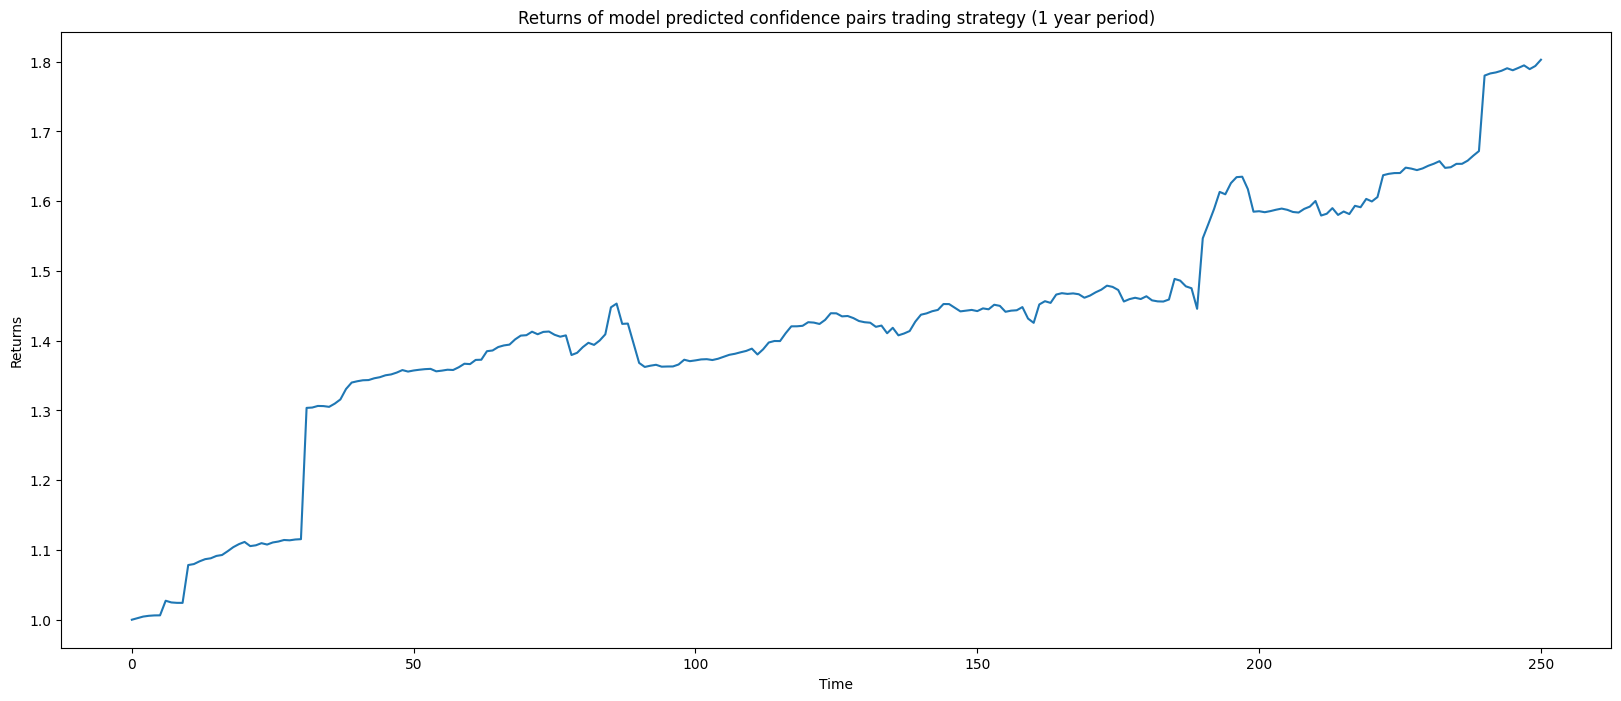

In [48]:
plot_rets = [max(1 + item, .98) for item in rets]

cumulative_rets = [np.prod(plot_rets[0:i]) for i in range(len(plot_rets))]

plt.figure(figsize = (20, 8))
plt.plot(cumulative_rets)
plt.title('Returns of model predicted confidence pairs trading strategy (1 year period)')
plt.xlabel('Time')
plt.ylabel('Returns')